## Final Project Submission¶

Student name: Eduardo Osorio
Student pace: part time 
Scheduled project review date/time:
Instructor name: Yish Lim
Blog post URL:

In [1]:
import pandas as pd
import numpy as np


kcc = pd.read_csv('data_files/kc_cleaned.csv')

continuous = ['price', 'sqft_living', 'sqft_lot']
categoricals = ['bedrooms', 'floors', 'condition', 'waterfront', 'grade', 'zipcode', 'sale_month']

kcc_cont = kcc[continuous]

# log features
log_names = [f'{column}_log' for column in kcc_cont.columns]

kcc_log = np.log(kcc_cont)
kcc_log.columns = log_names

# normalize (subract mean and divide by std)

def normalize(feature):
    return (feature - feature.mean()) / feature.std()

kcc_log_norm = kcc_log.apply(normalize)

# one hot encode categoricals
kcc_ohe = pd.get_dummies(kcc[categoricals], columns=['bedrooms', 'floors','condition', 'waterfront', 'zipcode', 'grade', 'sale_month'], drop_first=True)

preprocessed = pd.concat([kcc_log_norm, kcc_ohe], axis=1)

In [2]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, # Pvals over .05 are dropped
                       verbose=True):
 
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval)) #Adding pvals under the threshold

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval)) #drops pvals over thershold
        if not changed:
            break
    return included

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
X = preprocessed.drop('price_log', axis=1)
y = preprocessed['price_log']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
# Using a test size of 20%

In [6]:
result = stepwise_selection(X_train, y_train, verbose = True)
print('resulting features:')
print(result)
#Feed x_train and Y_train into the stepwise function

C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  sqft_living_log                with p-value 0.0
Add  zipcode_98004                  with p-value 3.16685e-169
Add  zipcode_98023                  with p-value 1.12407e-151
Add  waterfront_1.0                 with p-value 1.01358e-119
Add  zipcode_98112                  with p-value 1.5681e-126
Add  zipcode_98042                  with p-value 2.83349e-119
Add  grade_7                        with p-value 7.01213e-104
Add  grade_6                        with p-value 1.83508e-108
Add  grade_8                        with p-value 9.78168e-151
Add  grade_5                        with p-value 2.36747e-128
Add  zipcode_98092                  with p-value 2.29533e-121
Add  zipcode_98115                  with p-value 2.83681e-103
Add  zipcode_98103                  with p-value 2.9962e-104
Add  zipcode_98117                  with p-value 3.28745e-105
Add  zipcode_98105                  with p-value 6.33185e-94
Add  zipcode_98003                  with p-value 3.14528e-93
Add  zipcode_98038   

C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Add  zipcode_98045                  with p-value 8.62653e-16
Drop zipcode_98038                  with p-value 0.262317
Add  zipcode_98146                  with p-value 2.64112e-20
Drop zipcode_98055                  with p-value 0.846925
Add  zipcode_98019                  with p-value 2.93511e-21
Drop zipcode_98058                  with p-value 0.606361
Add  zipcode_98070                  with p-value 2.8005e-10
Add  zipcode_98014                  with p-value 1.66136e-09
Add  grade_12                       with p-value 3.96829e-07
Add  grade_13                       with p-value 3.84329e-40
Add  zipcode_98010                  with p-value 4.51611e-07
Add  zipcode_98038                  with p-value 3.29991e-08
Drop zipcode_98198                  with p-value 0.380095
Add  zipcode_98178                  with p-value 4.88063e-08
Drop zipcode_98022                  with p-value 0.314485
Add  zipcode_98058                  with p-value 9.68441e-11
Drop zipcode_98188                  with

In [7]:
import statsmodels.api as sm
X_fin = X_train[result]
X_with_intercept = sm.add_constant(X_fin)
model = sm.OLS(y_train,X_with_intercept).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     1231.
Date:                Wed, 28 Oct 2020   Prob (F-statistic):               0.00
Time:                        13:16:25   Log-Likelihood:                -5709.5
No. Observations:               15372   AIC:                         1.160e+04
Df Residuals:                   15282   BIC:                         1.229e+04
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.9539      0.071    -13.496      0.000      -1.092      -0.815
sqft_living_log     0.3820      0.005     73.679      0.000       0.372       0.392
zipcode_98004       2.0809      0.025     81.853      0.000       2.031       2.131
zipcode_98023      -0.1494      0.021     -7.261      0.000      -0.190      -0.109
waterfront_1.0      1.3235      0.034     39.023      0.000       1.257       1.390
zipcode_98112       1.9778      0.028     71.518      0.000       1.924       2.032
grade_7            -0.5896      0.016    -36.383      0.000      -0.621      -0.558
grade_6            -0.7336      0.019    -38.920      0.000      -0.771      -0.697
grade_8            -0.3790      0.016    -23.688      0.000      -0.410      -0.348
grade_5            -0.8652      0.030    -28.636      0.000      -0.924      -0.806
zipcode_98092      -0.0728      0.024     -3.051      0.002      -0.120      -0.026
zipcode_98115       1.5144      0.020     74.970      0.000       1.475       1.554
zipcode_98103       1.5471      0.021     74.963      0.000       1.507       1.588
zipcode_98117       1.4756      0.020     72.000      0.000       1.435       1.516
zipcode_98105       1.7781      0.029     60.970      0.000       1.721       1.835
zipcode_98003      -0.0781      0.027     -2.934      0.003      -0.130      -0.026
zipcode_98040       1.6200      0.028     58.840      0.000       1.566       1.674
zipcode_98119       1.8949      0.033     57.804      0.000       1.831       1.959
zipcode_98199       1.5955      0.026     61.055      0.000       1.544       1.647
zipcode_98033       1.4311      0.023     62.651      0.000       1.386       1.476
zipcode_98039       2.3861      0.059     40.761      0.000       2.271       2.501
zipcode_98107       1.6206      0.029     56.549      0.000       1.564       1.677
zipcode_98116       1.4339      0.025     56.570      0.000       1.384       1.484
grade_9            -0.0952      0.017     -5.546      0.000      -0.129      -0.062
zipcode_98122       1.5144      0.027     56.676      0.000       1.462       1.567
zipcode_98002      -0.1065      0.031     -3.469      0.001      -0.167      -0.046
zipcode_98032      -0.1404      0.038     -3.724      0.000      -0.214      -0.066
condition_3         0.4591      0.076      6.036      0.000       0.310       0.608
zipcode_98109       1.8834      0.044     42.338      0.000       1.796       1.971
zipcode_98102       1.7841      0.044     41.010      0.000       1.699       1.869
sqft_lot_log        0.1181      0.004     28.794      0.000       0.110       0.126
zipcode_98144       1.2407      0.025     49.151      0.000       1.191       1.290
zipcode_98136       1.2855      0.028     46.295      0.000       1.231       1.340
zipcode_98006       1.1572      0.022     52.973      0.000

In [8]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 70)
selector = selector.fit(X_train, y_train.values.ravel()) 
selector.support_ 

array([ True, False, False, False, False, False, False,  True, False,
        True, False, False, False,  True, False, False, False, False,
       False,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True, False, False, False,  True,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [9]:
selected_columns = X_train.columns[selector.support_ ]
linreg.fit(X_train[selected_columns],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
selected_columns

Index(['sqft_living_log', 'bedrooms_7', 'bedrooms_9', 'floors_3.0',
       'waterfront_1.0', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006',
       'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011',
       'zipcode_98014', 'zipcode_98019', 'zipcode_98024', 'zipcode_98027',
       'zipcode_98028', 'zipcode_98029', 'zipcode_98033', 'zipcode_98034',
       'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_98045',
       'zipcode_98052', 'zipcode_98053', 'zipcode_98056', 'zipcode_98058',
       'zipcode_98059', 'zipcode_98065', 'zipcode_98070', 'zipcode_98072',
       'zipcode_98074', 'zipcode_98075', 'zipcode_98077', 'zipcode_98102',
       'zipcode_98103', 'zipcode_98105', 'zipcode_98106', 'zipcode_98107',
       'zipcode_98108', 'zipcode_98109', 'zipcode_98112', 'zipcode_98115',
       'zipcode_98116', 'zipcode_98117', 'zipcode_98118', 'zipcode_98119',
       'zipcode_98122', 'zipcode_98125', 'zipcode_98126', 'zipcode_98133',
       'zipcode_98136', 'zipcod

In [11]:
yhat = linreg.predict(X[selected_columns])
y_hat_train = linreg.predict(X_train[selected_columns])
y_hat_test = linreg.predict(X_test[selected_columns])

In [12]:
SS_Residual = np.sum((y-yhat)**2)
SS_Total = np.sum((y-np.mean(y))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X[selected_columns].shape[1]-1)

In [13]:
r_squared

-7.270010866083567e+18

In [14]:
adjusted_r_squared

-7.296592258646944e+18

In [15]:
linreg.score(X_train[selected_columns], y_train)

0.8630643797734284

In [16]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 0.1376391088719585
Test Mean Squarred Error: 3.6340598020758503e+19


In [17]:
# from sklearn.linear_model import LinearRegression
# linreg = LinearRegression()

# linreg.fit(X_train, y_train)
# y_hat_test = linreg.predict(X_test)

In [18]:
# from sklearn.metrics import mean_squared_error
# test_residuals = y_hat_test - y_test

# test_mse = mean_squared_error(y_test, y_hat_test)
# test_mse

In [19]:
train_error_log = np.sqrt(mse_train)
test_error_log = np.sqrt(mse_test)
print(train_error_log)
print(test_error_log)

0.3709974513011626
6028316350.421443


In [20]:
train_error = np.exp(train_error_log)
test_error = np.exp(test_error_log)
print('train error:',train_error)
print('test error:', test_error)

train error: 1.4491793798601371
test error: inf


In [21]:
import scipy.stats as stats

In [22]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [24]:
# plt.scatter(model.predict(y_hat_train))

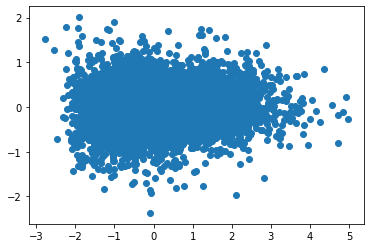

In [25]:
plt.scatter(y_hat_train, model.resid)
# plt.plot(y_hat_train(X_train[selected_columns])

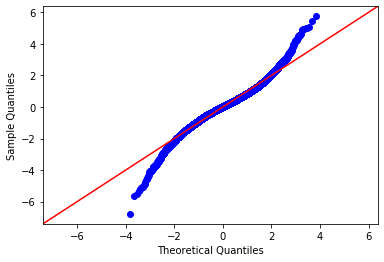

In [26]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

In [27]:
model = sm.OLS(y_test,X_test[selected_columns]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_log   R-squared (uncentered):                   0.856
Model:                            OLS   Adj. R-squared (uncentered):              0.853
Method:                 Least Squares   F-statistic:                              319.8
Date:                Wed, 28 Oct 2020   Prob (F-statistic):                        0.00
Time:                        13:16:27   Log-Likelihood:                         -1692.7
No. Observations:                3844   AIC:                                      3525.
Df Residuals:                    3774   BIC:                                      3963.
Df Model:                          70                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
sqft_living_log     0.4036      0.010     41.645      0.000       0.385       0.423
bedrooms_7         -0.0776      0.122     -0.637      0.524      -0.317       0.161
bedrooms_9         -0.6202      0.391     -1.586      0.113      -1.387       0.146
floors_3.0         -0.2493      0.040     -6.259      0.000      -0.327      -0.171
waterfront_1.0      1.2461      0.072     17.249      0.000       1.104       1.388
zipcode_98004       2.0387      0.056     36.593      0.000       1.929       2.148
zipcode_98005       1.1620      0.079     14.677      0.000       1.007       1.317
zipcode_98006       1.2384      0.042     29.308      0.000       1.156       1.321
zipcode_98007       1.1083      0.078     14.293      0.000       0.956       1.260
zipcode_98008       1.2370      0.050     24.551      0.000       1.138       1.336
zipcode_98010       0.1200      0.106      1.128      0.259      -0.089       0.329
zipcode_98011       0.7389      0.069     10.767      0.000       0.604       0.873
zipcode_98014       0.5703      0.082      6.934      0.000       0.409       0.731
zipcode_98019       0.5390      0.065      8.312      0.000       0.412       0.666
zipcode_98024       0.9668      0.127      7.592      0.000       0.717       1.217
zipcode_98027       0.9052      0.050     17.986      0.000       0.806       1.004
zipcode_98028       0.6869      0.053     13.030      0.000       0.584       0.790
zipcode_98029       0.9882      0.054     18.402      0.000       0.883       1.094
zipcode_98033       1.3358      0.043     30.875      0.000       1.251       1.421
zipcode_98034       0.9488      0.042     22.729      0.000       0.867       1.031
zipcode_98038       0.2100      0.040      5.306      0.000       0.132       0.288
zipcode_98039       2.6128      0.146     17.927      0.000       2.327       2.899
zipcode_98040       1.6856      0.057     29.821      0.000       1.575       1.796
zipcode_98045       0.5478      0.059      9.279      0.000       0.432       0.663
zipcode_98052       1.0725      0.039     27.376      0.000       0.996       1.149
zipcode_98053       1.0239      0.044     23.474      0.000       0.938       1.109
zipcode_98056       0.5529      0.046     11.964      0.000       0.462       0.644
zipcode_98058       0.2282      0.043      5.256      0.000       0.143       0.313
zipcode_98059       0.5671      0.045     12.740      0.000       0.480       0.654
zipcode_98065       0.7426      0.053     14.140      0.000       0.640       0.846
zipcode_98070       0.7031      0.084      8.388      0.000       0.539       0.867
zipcode_98072       0.8173      0.058     14.131      0.000       0.704       0.931
zipcode_98074       0.9264      0.045     20

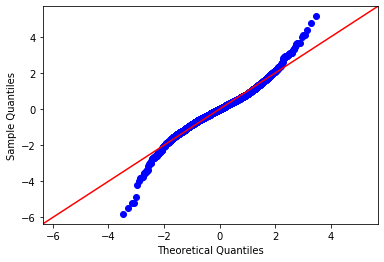

In [28]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

In [29]:
len(model.resid)

3844

In [30]:
X_train.shape

(15372, 110)

ValueError: x and y must be the same size

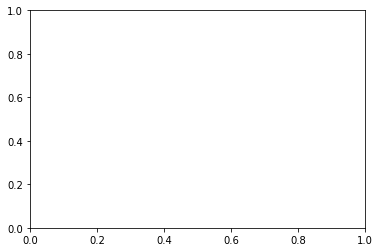

In [31]:
plt.scatter(model.predict(X_train[selected_columns]), model.resid)
plt.plot(model.predict(X_train[selected_columns]), [0 for i in range(len(X_train[selected_columns]))])